# Phase 1

In [6]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import zipfile

# Create output directory
output_dir = "motion_frames1"
os.makedirs(output_dir, exist_ok=True)

# Initialize video reader
cap = cv2.VideoCapture("/content/video_with_letters_precise (3).mp4")
ret, prev_frame = cap.read()
if not ret:
    raise Exception("Failed to read video.")

# Convert first frame to grayscale
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Enhance contrast using CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
prev_gray = clahe.apply(prev_gray)

frame_count = 1
kept = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = clahe.apply(gray)

    # Frame differencing
    diff = cv2.absdiff(prev_gray, gray)

    # Normalize difference to enhance contrast
    diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

    # Threshold to get binary mask
    _, binary = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Calculate motion ratio
    motion_ratio = np.sum(binary > 0) / binary.size

    if motion_ratio < 0.05:
        # Save this frame's binary mask
        path = os.path.join(output_dir, f"frame_{frame_count:03d}.png")
        cv2.imwrite(path, binary)
        kept += 1

    prev_gray = gray
    frame_count += 1

cap.release()

print(f"Saved {kept} frames with motion ratio < 5% to {output_dir}.")

# Create a zip file of the output directory for easy download
zip_path = f"{output_dir}.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=output_dir)
            zipf.write(file_path, arcname=os.path.join(output_dir, arcname))

print(f"Created zip archive at {zip_path} ready for download.")

Saved 17 frames with motion ratio < 5% to motion_frames1.
Created zip archive at motion_frames1.zip ready for download.


# Phase 2

In [2]:
!pip install moviepy noisereduce scipy

In [3]:
import moviepy.editor as mp
import noisereduce as nr
import scipy.io.wavfile as wav
import numpy as np

# Step 1: Extract audio from video
video = mp.VideoFileClip("/content/Fruit Animation.mp4")
audio_path = "extracted_audio.wav"
video.audio.write_audiofile(audio_path)

# Step 2: Read audio file
rate, data = wav.read(audio_path)

# Step 3: If stereo, use only one channel
if len(data.shape) == 2:
    data = data[:, 0]

# Step 4: Noise reduction
noise_sample = data[0:int(rate * 0.5)]  # Use first 0.5 seconds as noise profile

denoised = nr.reduce_noise(y=data, sr=rate, y_noise=noise_sample)

# Step 5: Save denoised audio
wav.write("denoised_audio.wav", rate, denoised.astype(np.int16))

print("✅ Audio denoised and saved as denoised_audio.wav.")


  if event.key is 'enter':



MoviePy - Writing audio in extracted_audio.wav


MoviePy - Done.


✅ Audio denoised and saved as denoised_audio.wav.


# Phase 3

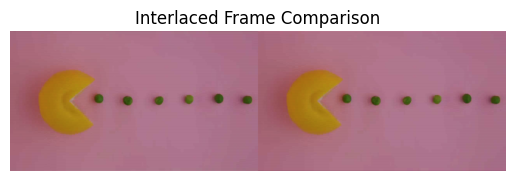

In [4]:
def interlace_frame(frame, field='odd'):
    interlaced = frame.copy()
    if field == 'odd':
        interlaced[::2] = (interlaced[::2] * 0.5).astype(np.uint8)
    else:
        interlaced[1::2] = (interlaced[1::2] * 0.5).astype(np.uint8)
    return interlaced

def interlace_video(input_path, output_path, field='odd'):
    cap = cv2.VideoCapture(input_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        interlaced = interlace_frame(frame, field)
        out.write(interlaced)

    cap.release()
    out.release()

# Apply both interlacings
interlace_video("Fruit Animation.mp4", "video_odd_interlaced.mp4", "odd")
interlace_video("Fruit Animation.mp4", "video_even_interlaced.mp4", "even")

# Create comparison image
cap1 = cv2.VideoCapture("video_odd_interlaced.mp4")
cap2 = cv2.VideoCapture("video_even_interlaced.mp4")
ret1, frame1 = cap1.read()
ret2, frame2 = cap2.read()
cap1.release()
cap2.release()

combined = np.hstack((frame1, frame2))
cv2.imwrite("interlaced_frame_comparison.png", combined)

# Display inline
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title("Interlaced Frame Comparison")
plt.axis('off')
plt.show()


# Bonus

In [5]:
import cv2
import numpy as np

# Load original video
cap = cv2.VideoCapture('/content/Fruit Animation.mp4')

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Output writer for flicker effect
out = cv2.VideoWriter('scanline_flicker.mp4', fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Copy the frame for both odd and even field versions
    odd_frame = frame.copy()
    even_frame = frame.copy()

    # Strongly darken even rows in odd_frame (simulate odd field)
    odd_frame[::2] = (odd_frame[::2] * 0.1).astype(np.uint8)

    # Strongly darken odd rows in even_frame (simulate even field)
    even_frame[1::2] = (even_frame[1::2] * 0.1).astype(np.uint8)

    # Alternate writing odd and even frames to simulate flicker
    out.write(odd_frame)
    out.write(even_frame)

# Cleanup
cap.release()
out.release()

print("⚡ Enhanced scanline flicker effect saved as scanline_flicker.mp4")


⚡ Enhanced scanline flicker effect saved as scanline_flicker.mp4
